In [19]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [21]:
path ="/content/drive/MyDrive/XLA/meo.jpg"
# Đọc ảnh màu
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


phần 1 : các phép biến đổi cường độ sáng


/tmp/ipython-input-4148279556.py:5: RuntimeWarning: overflow encountered in scalar add
  c = 255 / np.log(1 + np.max(img))
/tmp/ipython-input-4148279556.py:5: RuntimeWarning: divide by zero encountered in log
  c = 255 / np.log(1 + np.max(img))


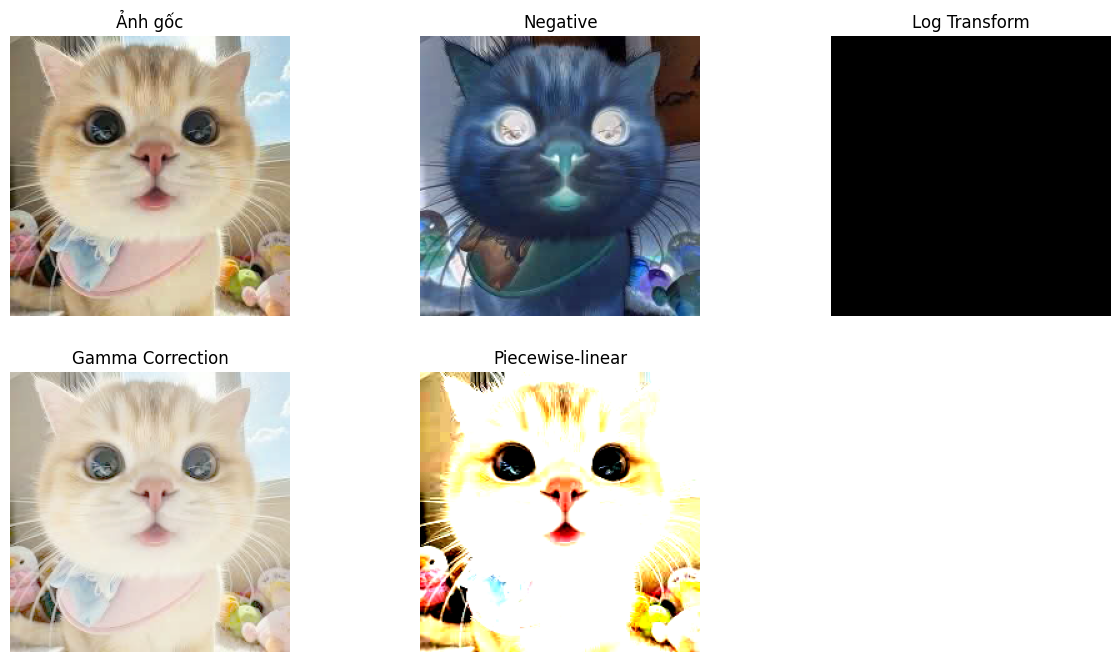

In [22]:
# 1. Negative Image
negative = 255 - img

# 2. Log Transformation
c = 255 / np.log(1 + np.max(img))
log_transformed = c * np.log(1 + img.astype(np.float32))
log_transformed = np.array(log_transformed, dtype=np.uint8)

# 3. Gamma Correction
gamma = 0.5   # < 1 làm sáng, > 1 làm tối
gamma_corrected = np.array(255 * ((img / 255) ** gamma), dtype=np.uint8)

# 4. Piecewise-linear Transformation
def piecewise_linear_transform(img):
    result = np.zeros_like(img)
    r1, s1 = 70, 0
    r2, s2 = 140, 255
    for i in range(3):  # xử lý từng kênh màu
        channel = img[:, :, i]
        channel = np.where(channel < r1,
                           (s1/r1) * channel,
                           np.where(channel < r2,
                                    ((s2-s1)/(r2-r1)) * (channel-r1) + s1,
                                    ((255-s2)/(255-r2)) * (channel-r2) + s2))
        result[:, :, i] = channel
    return result.astype(np.uint8)

piecewise = piecewise_linear_transform(img)
titles = ["Ảnh gốc", "Negative", "Log Transform", "Gamma Correction", "Piecewise-linear"]
images = [img, negative, log_transformed, gamma_corrected, piecewise]

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis("off")
plt.show()


Phần 2 : cân bằng lược đồ mức xám

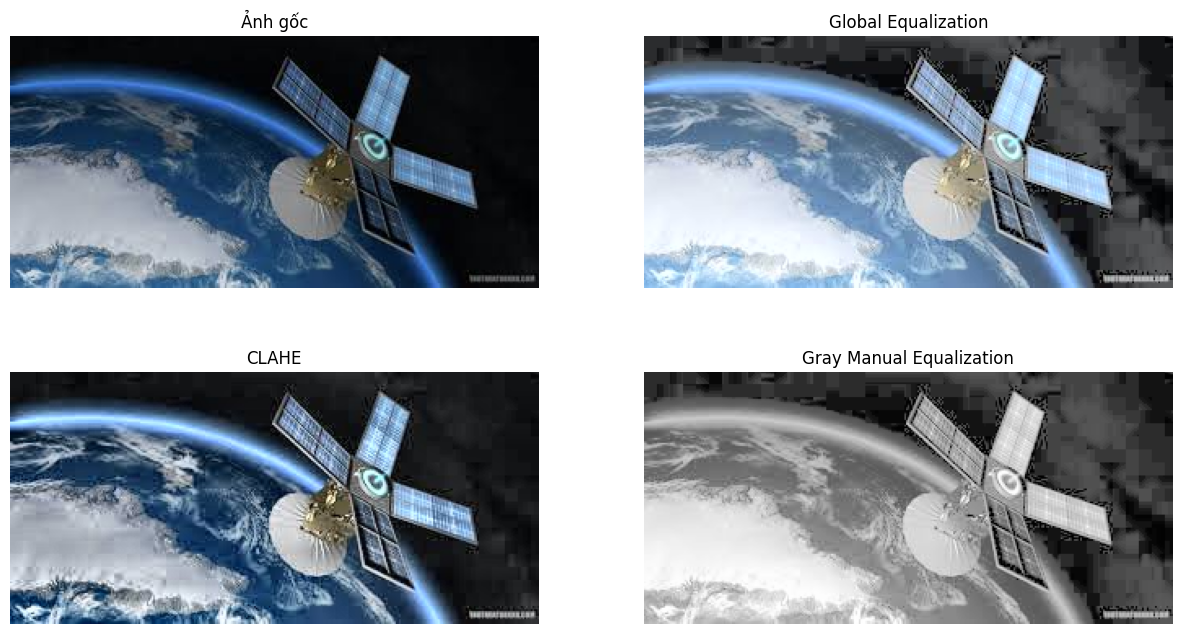

In [24]:
# Đọc ảnh màu từ Drive (sửa đường dẫn cho đúng ảnh của bạn)
path = "/content/drive/MyDrive/XLA/vetinh.jpg"  # đổi lại tên file
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ------------------------------
# 1. Histogram Equalization (Global)
# OpenCV hỗ trợ cho ảnh xám, nên ta sẽ chuyển đổi từng kênh YCrCb
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
y, cr, cb = cv2.split(img_ycrcb)
y_eq = cv2.equalizeHist(y)    # cân bằng trên kênh độ sáng
img_global = cv2.merge([y_eq, cr, cb])
img_global = cv2.cvtColor(img_global, cv2.COLOR_YCrCb2RGB)

# ------------------------------
# 2. Adaptive Histogram Equalization (CLAHE)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
y_clahe = clahe.apply(y)
img_clahe = cv2.merge([y_clahe, cr, cb])
img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_YCrCb2RGB)

# ------------------------------
# 3. Tự viết hàm cân bằng histogram (không dùng OpenCV sẵn)
def manual_hist_equalization(gray_img):
    # Tính histogram
    hist, bins = np.histogram(gray_img.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    # Chuẩn hóa cdf
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m, 0).astype('uint8')

    # Ánh xạ pixel theo cdf
    img_eq = cdf[gray_img]
    return img_eq

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
manual_eq = manual_hist_equalization(gray)

# ------------------------------
# Hiển thị kết quả
titles = ["Ảnh gốc", "Global Equalization", "CLAHE", "Gray Manual Equalization"]
images = [img, img_global, img_clahe, cv2.cvtColor(manual_eq, cv2.COLOR_GRAY2RGB)]

plt.figure(figsize=(15,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i], cmap="gray" if i==3 else None)
    plt.title(titles[i])
    plt.axis("off")
plt.show()


Phần 3 : ứng dụng biến đổi ảnh tăng cường chất lượng ảnh


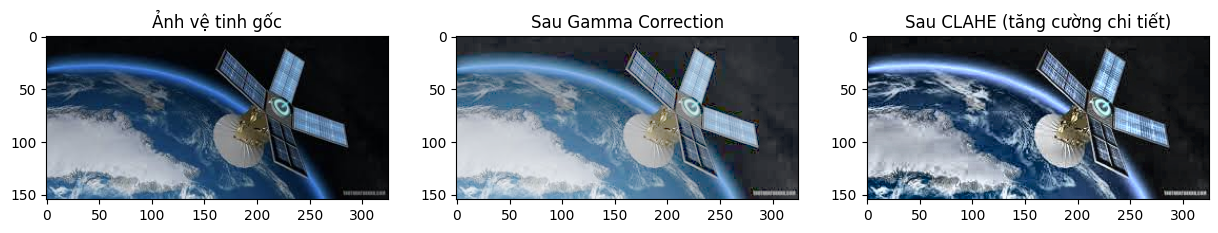

In [32]:
# Đọc ảnh vệ tinh
img = cv2.imread("/content/drive/MyDrive/XLA/vetinh.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 1. Biến đổi Gamma để điều chỉnh độ sáng (γ < 1 => sáng hơn)
gamma = 0.5
gamma_corrected = np.array(255*(img_rgb/255) ** gamma, dtype='uint8')

# 2. Tăng cường chi tiết bằng CLAHE (Histogram Equalization cục bộ)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
limg = cv2.merge((cl,a,b))
clahe_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

# Hiển thị kết quả
plt.figure(figsize=(15,6))
plt.subplot(1,3,1), plt.imshow(img_rgb), plt.title("Ảnh vệ tinh gốc")
plt.subplot(1,3,2), plt.imshow(gamma_corrected), plt.title("Sau Gamma Correction")
plt.subplot(1,3,3), plt.imshow(clahe_img), plt.title("Sau CLAHE (tăng cường chi tiết)")
plt.show()


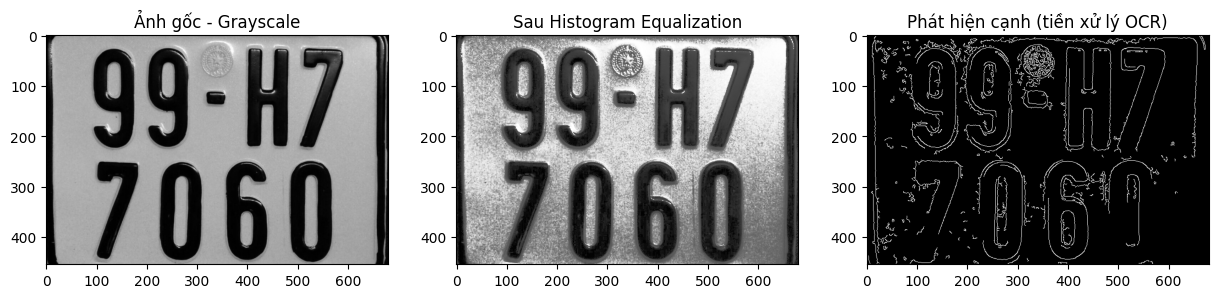

In [31]:
# Đọc ảnh màu
img = cv2.imread("/content/drive/MyDrive/XLA/bien-so-xe.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 1. Cân bằng Histogram để tăng độ tương phản
equalized = cv2.equalizeHist(img_gray)

# 2. Làm mịn ảnh để giảm nhiễu (GaussianBlur)
blurred = cv2.GaussianBlur(equalized, (5,5), 0)

# 3. Phát hiện cạnh (Edge Detection) - phục vụ nhận dạng ký tự
edges = cv2.Canny(blurred, 100, 200)

# Hiển thị kết quả
plt.figure(figsize=(15,6))
plt.subplot(1,3,1), plt.imshow(img_gray, cmap="gray"), plt.title("Ảnh gốc - Grayscale")
plt.subplot(1,3,2), plt.imshow(equalized, cmap="gray"), plt.title("Sau Histogram Equalization")
plt.subplot(1,3,3), plt.imshow(edges, cmap="gray"), plt.title("Phát hiện cạnh (tiền xử lý OCR)")
plt.show()
